## Description

This notebook implements image-to-text captioning for real image datasets. It is modified from the "Chat with BLIP-2" notebook illustrating usage of BLIP-2, a state-of-the-art vision-language model by Salesforce.

Original Notebook: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BLIP-2/Chat_with_BLIP_2.ipynb

HuggingFace docs: https://huggingface.co/docs/transformers/main/en/model_doc/blip_2.

## Set-up environment

Follow the set up instructions in (make sure you have finished running 'python download_data.py')

Compute advisory: Recommended to run in a GPU environment with high RAM.

In [1]:
%%time
from bitmind.image_dataset import ImageDataset
from bitmind.constants import DATASET_META
import numpy as np
import random

import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BlipProcessor
from transformers import pipeline, BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

/root/miniconda3/envs/bitmind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-02 17:34:14.300361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 17:34:14.426862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 17:34:14.427941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 17:34:14.611825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow bin

CPU times: user 6.36 s, sys: 2.68 s, total: 9.04 s
Wall time: 10.8 s


### Load model and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [2]:
%%time
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# old
#processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
#model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) 

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b-coco")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b-coco", torch_dtype=torch.float16) 
model.to(device)

Loading checkpoint shards: 100%|████████████████████████| 2/2 [00:19<00:00,  9.52s/it]


CPU times: user 23.6 s, sys: 24.1 s, total: 47.6 s
Wall time: 39.2 s


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

### Load Real Image Datasets

In [3]:
%%time
print("Loading real datasets")
real_image_datasets = [
    ImageDataset(ds['path'], 'test', ds.get('name', None), ds['create_splits'])
    for ds in DATASET_META['real']
]
real_image_datasets

Loading real datasets
CPU times: user 4.72 s, sys: 5.78 s, total: 10.5 s
Wall time: 46.2 s


#### Display random sample image from real image datasets

{'image': <PIL.Image.Image image mode=RGB size=350x263 at 0x7FB21C3445B0>, 'id': 'https://farm1.staticflickr.com/8511/8495083339_7278124591_o.jpg'}


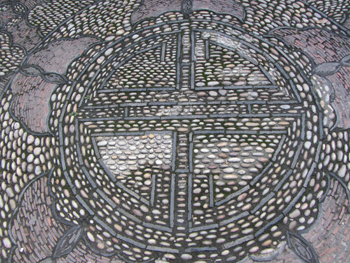

In [4]:
# select a dataset at random
real_dataset = real_image_datasets[np.random.randint(0, len(real_image_datasets))]
# select a dict containing a sample imagee at random
sample = real_dataset.sample(k=1)[0][0]
image = sample['image']
print(sample)
image

{'image': <PIL.Image.Image image mode=RGB size=2304x1728 at 0x7FB2917DF880>, 'id': 'https://farm8.staticflickr.com/3622/3318305599_bfffb86691_o.jpg'}


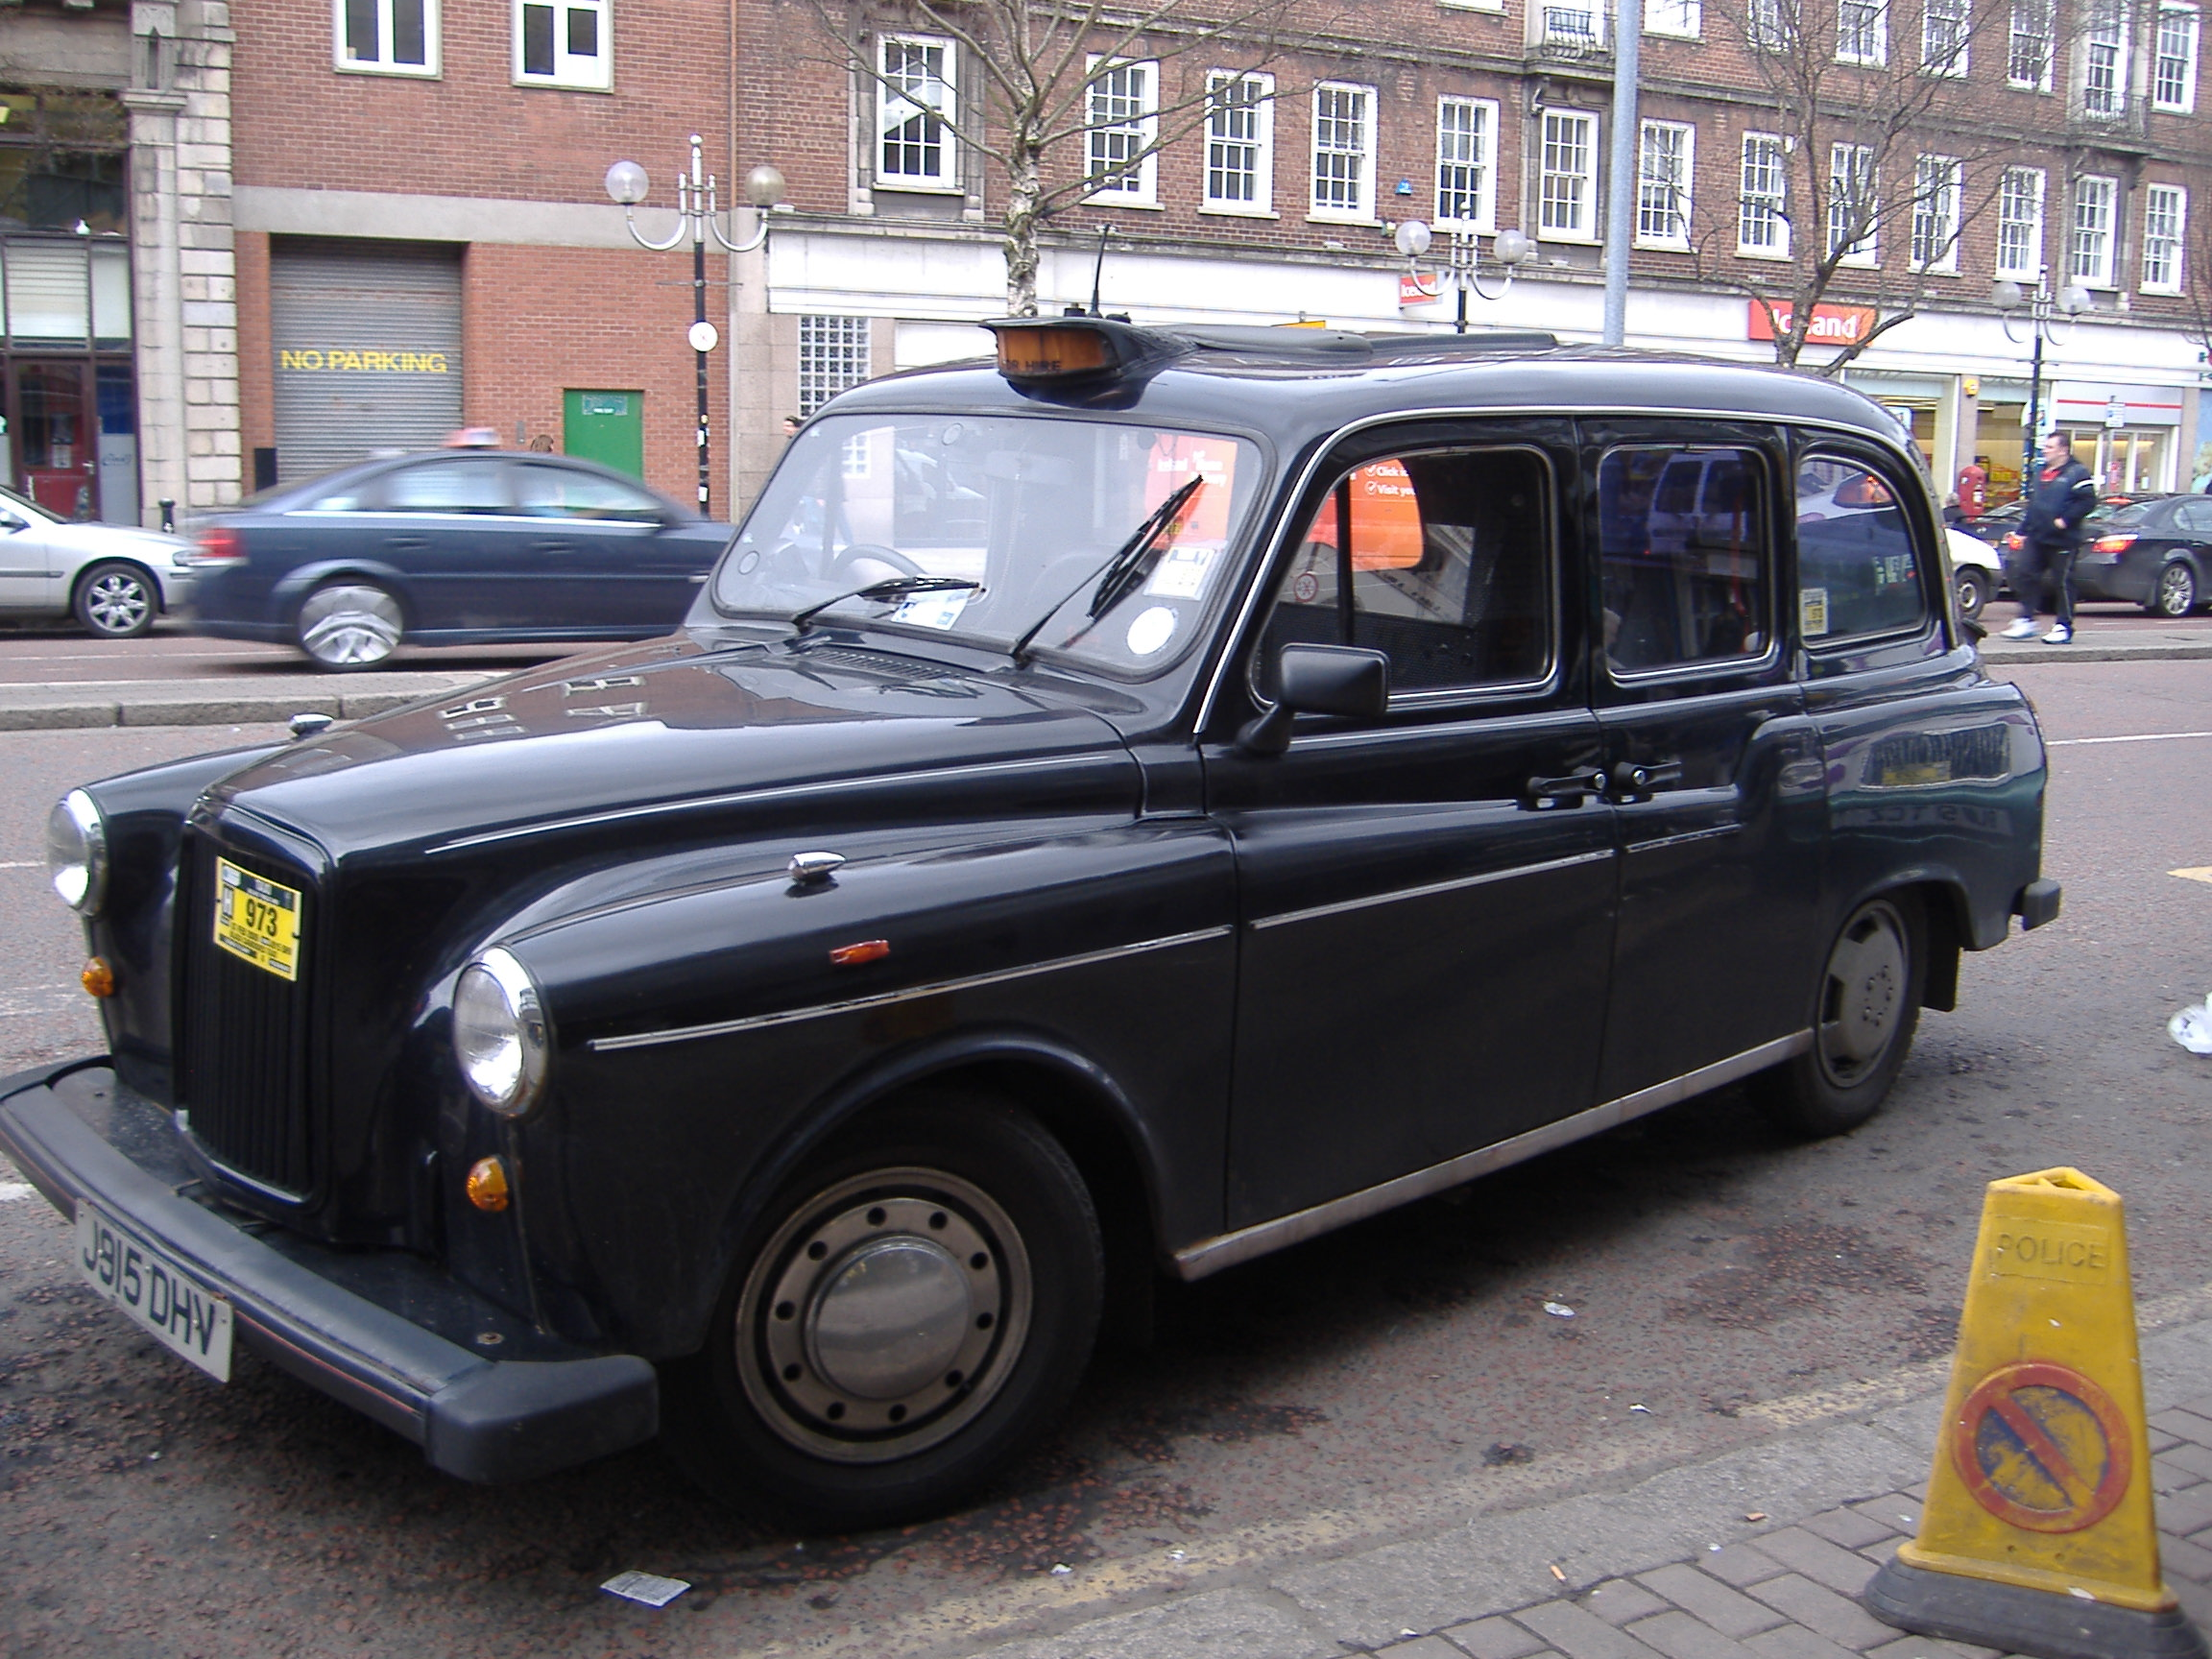

In [5]:
sample = real_dataset.sample(k=1)[0][0]
image = sample['image']
print(sample)
image

## Image captioning

If you don't provide any text prompt, then the model will by default start generating text from the BOS (beginning-of-sequence) token. So it will generate a caption for the image.

In [6]:
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a black taxi cab is parked on the side of the street


## Prompted image captioning

You can provide a text prompt, which the model will continue given the image.

In [7]:
%%time
prompt = "this is a picture of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a black taxi cab parked on the side of the road
CPU times: user 4.2 s, sys: 0 ns, total: 4.2 s
Wall time: 4.12 s


## Visual question answering (VQA)

In [8]:
prompt = "Question: what is this a picture of? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a taxi cab


In [9]:
prompt = "Question: Describe this picture in detail starting with 'this is a picture of...'. Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=50)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


This is a picture of a taxi cab


## Chat-based prompting

We can create a ChatGPT-like interface by simply concatenating each generated response to the conversation. We prompt the model with some text (like "which city is this?"), the model generates an answer for it "Singapore"), which we just concatenate to the conversation. Then we ask a follow-up question ("why?") which we also just concatenate and feed to the model.

This means that the context can't be too long - models like OPT and T5 (the language models being used in BLIP-2) have a context length of 512 tokens.

In [10]:
prompts = [
    "A picture of",
    "The subject(s), if any, are",
    "The setting is",
    "The foreground is",
    "the background is",
    "The color(s) are",
    "The texture(s) are",
    "The emotion/mood is",
    "The image medium is",
    "The image style is"
]
answers = ['']*len(prompts)
#prompts2answers = {}
#template = "Question: {} Answer: {}"

In [11]:
def generate_description():
    description = ""
    for i, prompt in enumerate(prompts):
        # Append prompt to description to build context history
        description += prompt + ' '
        inputs = processor(image, text=description, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        print(str(i) + '. Prompt:',prompt)
        print(str(i)+'. Answer:',answer)
        answers[i] = answer
        if len(answer) > 0:
            # Append answer to description to build context history
            description += answer + '.'
        else:
            print(i, '-empty')
            description -= (prompt + ' ')
    return description

In [12]:
%%time
description = generate_description()

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


0. Prompt: A picture of
0. Answer: a black taxi cab parked on the side of the road


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


1. Prompt: The subject(s), if any, are
1. Answer: not identified


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


2. Prompt: The setting is
2. Answer: a city street.


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


3. Prompt: The foreground is
3. Answer: a sidewalk.The background is a brick wall.


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


4. Prompt: the background is
4. Answer: a brick wall.


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


5. Prompt: The color(s) are
5. Answer: black..The subject(s) are not identified.


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


6. Prompt: The texture(s) are
6. Answer: icky..The texture(s) are icky..The texture(s) are icky..


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


7. Prompt: The emotion/mood is
7. Answer: icky..The emotion/mood is icky..The emotion/mood is icky..


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


8. Prompt: The image medium is
8. Answer: icky..The image medium is icky..The image medium is icky..The image medium is


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


9. Prompt: The image style is
9. Answer: icky..The image style is icky..The image style is icky..The image style is
CPU times: user 47.7 s, sys: 632 ms, total: 48.3 s
Wall time: 47 s


In [13]:
description

'A picture of a black taxi cab parked on the side of the road.The subject(s), if any, are not identified.The setting is a city street..The foreground is a sidewalk.The background is a brick wall..the background is a brick wall..The color(s) are black..The subject(s) are not identified..The texture(s) are icky..The texture(s) are icky..The texture(s) are icky...The emotion/mood is icky..The emotion/mood is icky..The emotion/mood is icky...The image medium is icky..The image medium is icky..The image medium is icky..The image medium is.The image style is icky..The image style is icky..The image style is icky..The image style is.'

## Summarize image captions

### Using microsoft/phi-1.5 LLM with AutoTokenizer and AutoModelForCausalLM

In [14]:
def summarize_text(input_text):
    # Load model and tokenizer
    model_name = "microsoft/phi-1.5"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    # Encode text and generate summary
    inputs = tokenizer.encode(input_text, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs, max_length=150, num_beams=5, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [ ]:
%%time
# Generate summary
summary = summarize_text(description)
print(summary)

### Using BitsAndBytes to load more light-weight model

In [ ]:
%%time
#quantization_config = BitsAndBytesConfig(load_in_4bit=True)
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
pipe = pipeline("text-generation", "microsoft/phi-1_5", model_kwargs={"quantization_config": quantization_config})

In [ ]:
%%time
response = pipe('Please write a paragraph summary of these text captions: ' + description, max_new_tokens=100)

In [ ]:
print(type(response))
print(response[0])

### Transformer chat pipeline testing

In [ ]:
# # chat = [
# #     {"role": "system", "content": "You are a descriptor that takes text annotations of images and turns them into paragraph descriptions."},
# #     {"role": "user", "content": description}
# # ]
# pipe = pipeline("text-generation", "openai-community/gpt2", device=0) #use gpu; can use device_map=auto if accelerate is installed
# response = pipe('Please turn this series of text captions into one cohesive paragraph description: ' + description, max_new_tokens=100)
# print(response)# print(response[0]['generated_text'][-1]['content'])

In [ ]:
# pipe = pipeline("text-generation", "microsoft/phi-1_5", device_map='auto', model_kwargs={"quantization_config": quantization_config})